In [ ]:
!pip install --quiet openai google-cloud-aiplatform "anthropic[bedrock]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.5/863.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.7 MB/s eta 0:00:00


In [ ]:
!gcloud auth application-default login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=NikB70gtutF8TkHtUpz5VldzRI2IDn&prompt=consent&token_usage=remote&access_type=offline&code_challenge=9M3s7zbfeUFWF1j3LoQ-JudWK250dX2yOms5TAglNSM&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0ATx3LY4VGA3Z2udtju5e5Z7Cv3bvnYICVK1VIU-DVfy8XEcvSmw129VwKhOCx43P_b5pRQ

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Ca

In [ ]:
import pandas as pd
import numpy as np
from google.colab import userdata
from openai import OpenAI, AzureOpenAI
import vertexai
from vertexai.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models
from anthropic import AnthropicBedrock

llm_provider = "ANTHROPIC"  # GOOGLE, OPENAI, ANTHROPIC

open_ai_client = AzureOpenAI(
  azure_endpoint = userdata.get("AZURE_OPENAI_ENDPOINT"),
  api_key=userdata.get("AZURE_OPENAI_API_KEY"),
  api_version="2024-02-01",
  max_retries=8
)

vertexai.init(project="", location="us-central1")

anthropic_client = AnthropicBedrock(
    aws_access_key=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_key=userdata.get('AWS_SECRET_ACCESS_KEY'),
    aws_region="us-east-1",
)

## LLM Automatic Grader with images

In [ ]:
!pip install --quiet pymupdf pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 27.3 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
from PIL import Image, ImageEnhance
import io
import base64
import os
import re

def pdf_to_base64_images(pdf_path):
    pdf_document = fitz.open(pdf_path)
    base64_images = []

    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        # Increase DPI
        zoom = 2.0  # Zoom factor for higher resolution
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)

        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Enhance image quality
        img = enhance_image(img)

        # Convert to bytes
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_bytes = buffered.getvalue()

        # Encode to base64
        img_base64 = base64.b64encode(img_bytes).decode('utf-8')
        base64_images.append(img_base64)

    return base64_images

def enhance_image(image):
    # Enhance image quality
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(2.0)  # Increase sharpness

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Increase contrast

    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)  # Increase brightness

    return image

def extract_student_grade_and_feedback_from_xml(xml_data):
  grade_and_feedback = {}
  xml_tags = ["feedback", "nota"]

  for tag in xml_tags:
      pattern = fr"<{tag}>(.*?)</{tag}>"
      matches = re.findall(pattern, xml_data, re.DOTALL)
      for match in matches:
          text = match.strip()
          grade_and_feedback[tag] = text


  return grade_and_feedback

def grade_student_answers_with_vision_open_ai(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number):
  response = open_ai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": "Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<questao-numero>1</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>\n\n<questao>\n<questao-numero>2</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, exam_base64_images),
          {
            "type": "text",
            "text": f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}"
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, student_answers_base64_images),
          {
            "type": "text",
            "text": f"Estas foram as respostas do aluno na prova. Considerando as questões originais da prova, o gabarito e as respostas do aluno.\n\nForneça o feedback e a nota do aluno para a questão {question_number}. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<questao-numero>{question_number}</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
          }
        ]
      }
    ],
    temperature=0.8,
    max_tokens=4095,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return response.choices[0].message.content

def grade_student_answers_with_vision_gemini(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number):
  model = GenerativeModel(
    "gemini-1.5-flash-001", # gemini-1.5-pro-001 or gemini-1.5-flash-001
    system_instruction=["Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<questao-numero>1</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>\n\n<questao>\n<questao-numero>2</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"]
  )
  chat = model.start_chat()

  generation_config = {
      "max_output_tokens": 8192,
      "temperature": 0.8,
      "top_p": 0.95,
  }
  response = chat.send_message(
      [
        *map(lambda base64_image: Part.from_data(
          mime_type="image/png",
          data=base64.b64decode(base64_image)), exam_base64_images),
        f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}",
        *map(lambda base64_image: Part.from_data(
          mime_type="image/png",
          data=base64.b64decode(base64_image)), student_answers_base64_images),
        f"Estas foram as respostas do aluno na prova. Considerando as questões originais da prova, o gabarito e as respostas do aluno.\n\nForneça o feedback e a nota do aluno para a questão {question_number}. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<questao-numero>{question_number}</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
        ],
      generation_config=generation_config
  )

  return response.text

def grade_student_answers_with_vision_anthropic(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number):
  response = anthropic_client.messages.create(
      model="anthropic.claude-3-5-sonnet-20240620-v1:0",
      max_tokens=4000,
      temperature=0.8,
      system="Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<questao-numero>1</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>\n\n<questao>\n<questao-numero>2</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>",
      messages=[
          {
            "role": "user",
            "content": [
              *map(lambda base64_image: {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": base64_image
                }
              }, exam_base64_images),
              {
                "type": "text",
                "text": f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}"
              },
              *map(lambda base64_image: {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": base64_image
                }
              }, student_answers_base64_images),
              {
                "type": "text",
                "text": f"Estas foram as respostas do aluno na prova. Considerando as questões originais da prova, o gabarito e as respostas do aluno.\n\nForneça o feedback e a nota do aluno para a questão {question_number}. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<questao-numero>{question_number}</questao-numero>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
              }
            ]
          }
      ]
  )
  return response.content[0].text

def grade_student_answers_with_vision(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number):
  if llm_provider == "OPENAI":
    return grade_student_answers_with_vision_open_ai(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number)
  elif llm_provider == "GOOGLE":
    return grade_student_answers_with_vision_gemini(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number)
  elif llm_provider == "ANTHROPIC":
    return grade_student_answers_with_vision_anthropic(exam_base64_images, exam_answer_key, student_answers_base64_images, question_number)

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

exam_file_path = "exam/exam.pdf"
exam_answer_sheet_path = "exam/exam_answer_sheet.txt"
number_of_questions_in_exam = 5
student_exam_answers_folder_path = "student_exam_answers"

def grade_and_extract(file_name, exam_base64_images, exam_answer_key, number_of_questions_in_exam):
    pdf_path = os.path.join(student_exam_answers_folder_path, file_name)
    student_answers_base64_images = pdf_to_base64_images(pdf_path)
    student_grades = []

    for question_number in range(1, number_of_questions_in_exam + 1):
        student_exam_grade_and_feedback_xml = grade_student_answers_with_vision(
            exam_base64_images, exam_answer_key, student_answers_base64_images, question_number
        )
        student_exam_grade_and_feedback = extract_student_grade_and_feedback_from_xml(
            student_exam_grade_and_feedback_xml
        )
        student_exam_grade_and_feedback["arquivo"] = file_name
        student_exam_grade_and_feedback["questao"] = question_number
        student_grades.append(student_exam_grade_and_feedback)

    return student_grades

exam_base64_images = pdf_to_base64_images(exam_file_path)

with open(exam_answer_sheet_path, 'r') as file:
    exam_answer_key = file.read()

students_grades = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for file_name in os.listdir(student_exam_answers_folder_path):
        if file_name.endswith(".pdf"):
            futures.append(executor.submit(grade_and_extract, file_name, exam_base64_images, exam_answer_key, number_of_questions_in_exam))

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing student answer files..."):
        students_grades.extend(future.result())

# Ensure the correct column order
columns_order = ["arquivo", "questao"]
if students_grades:
    additional_columns = [col for col in students_grades[0].keys() if col not in columns_order]
    columns_order.extend(additional_columns)

pd.DataFrame(students_grades).to_csv("grades.csv", index=False, columns=columns_order)

Processing student answer files...: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


### Insights:
- A adição de `<nota-maxima-por-alternativa>` no gabarito ajudou.
- A adição de `<criterios-para-pontuar-a-questao>` ajudou.
- A adição de "Seja rigoroso na correção." ajudou.

## LLM Automatic Grader

In [ ]:
import re

def extract_student_grade_and_feedback_from_xml(xml_data):
  grade_and_feedback = {}
  xml_tags = ["feedback", "nota"]

  for tag in xml_tags:
      pattern = fr"<{tag}>(.*?)</{tag}>"
      matches = re.findall(pattern, xml_data, re.DOTALL)
      for match in matches:
          text = match.strip()
          grade_and_feedback[tag] = text


  return grade_and_feedback

def grade_student_answers_open_ai(question, question_answer, student_answer):
  response = open_ai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": "Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"Esta é a questão:\n\n{question}\n\nE este é o gabarito:\n\n{question_answer}\n\nA nota máxima para essa questão é 1.0."
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"Esta é a resposta do aluno na prova:\n\n{student_answer}\n\nConsiderando a questão da prova, o gabarito e a resposta do aluno.\n\nForneça o feedback e a nota do aluno para a questão. Forneça uma nota entre 0.0 e 1.0. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
          }
        ]
      }
    ],
    temperature=0.8,
    max_tokens=4095,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return response.choices[0].message.content

def grade_student_answers_gemini(question, question_answer, student_answer):
  model = GenerativeModel(
    "gemini-1.5-pro-001", # gemini-1.5-pro-001 or gemini-1.5-flash-001
    system_instruction=["Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"]
  )
  chat = model.start_chat()

  generation_config = {
      "max_output_tokens": 8192,
      "temperature": 0.8,
      "top_p": 0.95,
  }
  response = chat.send_message(
      [
        f"Esta é a questão:\n\n{question}\n\nE este é o gabarito:\n\n{question_answer}\n\nA nota máxima para essa questão é 1.0.",
        f"Esta é a resposta do aluno na prova:\n\n{student_answer}\n\nConsiderando a questão da prova, o gabarito e a resposta do aluno.\n\nForneça o feedback e a nota do aluno para a questão. Forneça uma nota entre 0.0 e 1.0. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
      ],
      generation_config=generation_config
  )

  return response.text

def grade_student_answers_anthropic(question, question_answer, student_answer):
  response = anthropic_client.messages.create(
      model="anthropic.claude-3-5-sonnet-20240620-v1:0",
      max_tokens=4000,
      temperature=0.8,
      system="Você é um tutor que corrige provas. Você receberá questões de prova junto com um gabarito.\n\nVocê receberá respostas de estudantes para cada questão.\n\nSeu objetivo é analisar a questão original, o gabarito e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno entre as tags <feedback></feedback> seguido de uma nota para a resposta entre as tags <nota></nota>.\n\nCada questão da prova vale uma nota diferente, extraia da questão original qual é a nota máxima da questão.\n\nA nota entre as tags <nota> deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.\n\nAntes de fornecer o feedback e nota, deixe explícito os critérios que você usará para avaliar o aluno na questão, entre as tags <criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>.\n\nSeu feedback, <feedback>, deve ser falando diretamente para o aluno ler.\n\nForneça o feedback e a nota para cada questão. No seguinte formato.\nExemplo:\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>",
      messages=[
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": f"Esta é a questão:\n\n{question}\n\nE este é o gabarito:\n\n{question_answer}\n\nA nota máxima para essa questão é 1.0."
              },
              {
                "type": "text",
                "text": f"Esta é a resposta do aluno na prova:\n\n{student_answer}\n\nConsiderando a questão da prova, o gabarito e a resposta do aluno.\n\nForneça o feedback e a nota do aluno para a questão. Forneça uma nota entre 0.0 e 1.0. Seja rigoroso na correção. No seguinte formato.\n<questao>\n<criterios-para-pontuar-a-questao></criterios-para-pontuar-a-questao>\n<feedback></feedback>\n<nota></nota>\n</questao>"
              }
            ]
          }
      ]
  )
  return response.content[0].text

def grade_student_answers(question, question_answer, student_answer):
  if llm_provider == "OPENAI":
    return grade_student_answers_open_ai(question, question_answer, student_answer)
  elif llm_provider == "GOOGLE":
    return grade_student_answers_gemini(question, question_answer, student_answer)
  elif llm_provider == "ANTHROPIC":
    return grade_student_answers_anthropic(question, question_answer, student_answer)

In [ ]:
exam_questions_df = pd.read_csv("Exam questions csv")
student_answers_df = pd.read_csv("Student answers csv")

In [ ]:
import concurrent.futures
from tqdm import tqdm

def process_student_answer(student_answer_row):
    question_number = student_answer_row['Question Number']
    question = exam_questions_df[exam_questions_df['Question Number'] == question_number]['Question'].iloc[0]
    question_answer = exam_questions_df[exam_questions_df['Question Number'] == question_number]['Correct Answer'].iloc[0]
    student_answer = student_answer_row['Answer']
    student_exam_grade_and_feedback_xml = grade_student_answers(question, question_answer, student_answer)
    student_exam_grade_and_feedback = extract_student_grade_and_feedback_from_xml(
            student_exam_grade_and_feedback_xml
        )
    student_exam_grade_and_feedback["id_resposta"] = student_answer_row['Answer Id']
    student_exam_grade_and_feedback["questao"] = question_number
    return student_exam_grade_and_feedback

student_answer_rows = [row for _, row in student_answers_df.iterrows()]

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm(executor.map(process_student_answer, student_answer_rows), total=len(student_answer_rows), desc="Processing student answers"))

student_grades = results


columns_order = ["id_resposta", "questao"]
if student_grades:
    additional_columns = [col for col in student_grades[0].keys() if col not in columns_order]
    columns_order.extend(additional_columns)

pd.DataFrame(student_grades).to_csv("grades.csv", index=False, columns=columns_order)

Processing student answers: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it]


## Compute Metrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import jensenshannon

# Função para calcular MAE e RMSE
def calculate_metrics(true_grades, predicted_grades):
    mae = mean_absolute_error(true_grades, predicted_grades)
    rmse = np.sqrt(mean_squared_error(true_grades, predicted_grades))
    return mae, rmse

# Função para calcular a distância de Jensen-Shannon
def js_distance(p, q):
    return jensenshannon(p, q, base=2)

# Plotar o gráfico de densidade para as notas normalizadas de cada modelo e as notas verdadeiras
def plot_normalized_grades(data, models):
  plt.figure(figsize=(14, 8))
  for model in models:
      data[model].plot(kind='kde', label=model, linewidth=2)
  data['True Grade Normalized'].plot(kind='kde', label='True Grade Normalized', linewidth=2, linestyle='--', color='black')
  plt.xlabel('Nota Normalizada')
  plt.ylabel('Densidade')
  plt.title('Densidade das Notas Normalizadas por Modelo')
  plt.legend()
  plt.grid(True)
  plt.show()

# Carregar o arquivo CSV
file_path = 'Grades from models.csv'
data = pd.read_csv(file_path)

# Definir as colunas dos modelos e a coluna de notas verdadeiras
models = ['GPT-4o normalized grade', 'Gemini Flash normalized grade', 'Gemini Pro normalized grade', 'Claude Sonnet 3.5 normalized grade']
true_grades = data['True Grade Normalized']

In [ ]:
# Cálculo das métricas MAE e RMSE para cada modelo
metrics = {}
for model in models:
    mae, rmse = calculate_metrics(true_grades, data[model])
    metrics[model] = {'MAE': mae, 'RMSE': rmse}

metrics_df = pd.DataFrame(metrics).transpose()
print("MAE e RMSE para cada modelo:")
metrics_df

MAE e RMSE para cada modelo:


,MAE,RMSE
GPT-4o normalized grade,0.164533,0.216967
Gemini Flash normalized grade,0.151733,0.207827
Gemini Pro normalized grade,0.188000,0.236925
Claude Sonnet 3.5 normalized grade,0.193467,0.230747


In [ ]:
# Converter os resultados em DataFrame para visualização
metrics_df = pd.DataFrame(metrics).transpose()

# Calcular a matriz de correlação entre as notas atribuídas pelos diferentes LLMs e as notas verdadeiras
correlation_matrix = data[models + ['True Grade Normalized']].corr()

print("Matriz de Correlação:")
correlation_matrix

Matriz de Correlação:


,GPT-4o normalized grade,Gemini Flash normalized grade,Gemini Pro normalized grade,Claude Sonnet 3.5 normalized grade,True Grade Normalized
GPT-4o normalized grade,1.000000,0.960165,0.964036,0.966748,0.962484
Gemini Flash normalized grade,0.960165,1.000000,0.961851,0.963421,0.938430
Gemini Pro normalized grade,0.964036,0.961851,1.000000,0.968795,0.939230
Claude Sonnet 3.5 normalized grade,0.966748,0.963421,0.968795,1.000000,0.939970
True Grade Normalized,0.962484,0.938430,0.939230,0.939970,1.000000


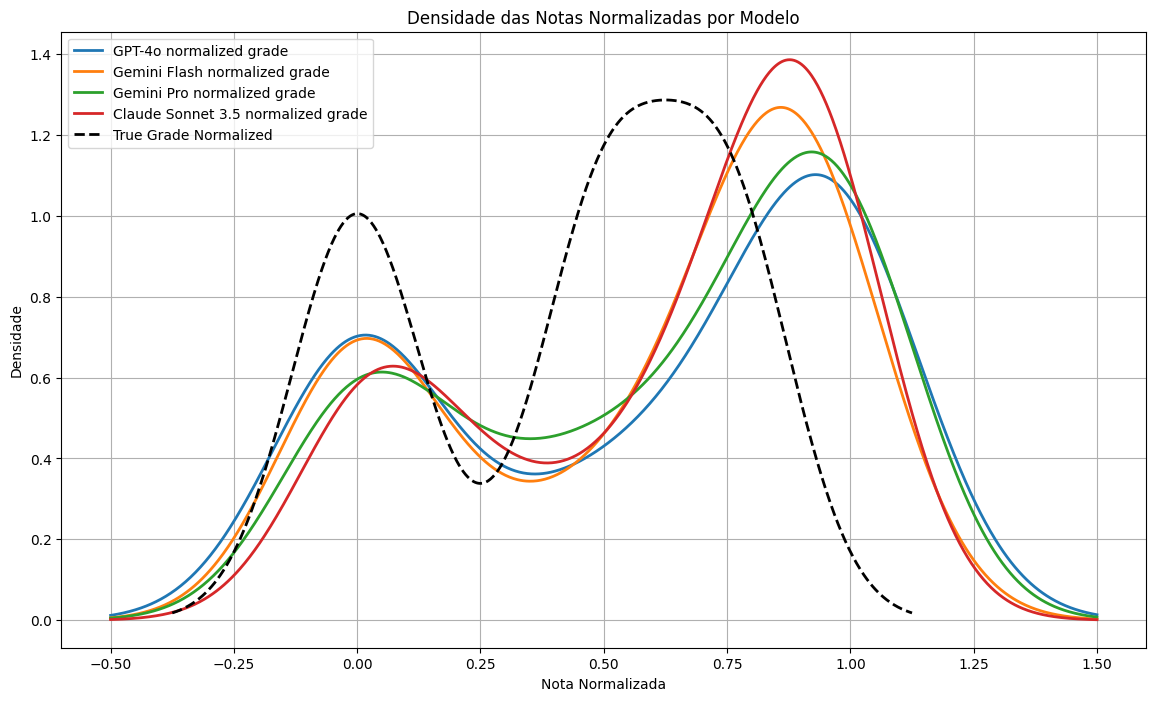

In [ ]:
plot_normalized_grades(data, models)

In [ ]:
# Calcular a distância de Jensen-Shannon para cada modelo em relação às notas verdadeiras
js_distances = {}
for model in models:
    js_distances[model] = js_distance(true_grades, data[model])

# Converter os resultados em DataFrame para visualização
js_distances_df = pd.DataFrame.from_dict(js_distances, orient='index', columns=['Jensen-Shannon Distance'])
print("Distância de Jensen-Shannon entre as notas dos modelos e as notas verdadeiras:")
js_distances_df

Distância de Jensen-Shannon entre as notas dos modelos e as notas verdadeiras:


,Jensen-Shannon Distance
GPT-4o normalized grade,0.118226
Gemini Flash normalized grade,0.153610
Gemini Pro normalized grade,0.186651
Claude Sonnet 3.5 normalized grade,0.207623
